# preprocessing

In [84]:
!rm -rf TabularDS  # Remove the existing directory
!git clone https://github.com/ItamarBerger/TabularDS


Cloning into 'TabularDS'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 397 (delta 0), reused 5 (delta 0), pack-reused 387 (from 2)
Receiving objects: 100% (397/397), 24.57 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (172/172), done.
Updating files: 100% (17/17), done.


In [96]:
# load dataset
import pandas as pd
data = pd.read_csv('/content/TabularDS/final_project/data/rating.csv')
movies_data = pd.read_csv('/content/TabularDS/final_project/data/movie.csv')

In [97]:
df = data
data.head()

,userId,movieId,rating,timestamp
0,122270,8360,3.5,2012-04-22 01:07:04
1,49018,32,2.0,2001-09-11 07:50:36
2,89527,109374,3.5,2015-01-06 09:26:40
3,106704,1060,3.0,2000-01-22 21:27:57
4,47791,1732,2.0,2006-01-19 15:48:23


In [105]:
movie_popularity = data.groupby('movieId')['userId'].nunique().sort_values(ascending=False)

# Select the top 10% most popular movies
top_10_percent_count = int(0.1 * len(movie_popularity))
top_movies = movie_popularity.head(top_10_percent_count).index.tolist()

# Filter dataset to only include these movies
filtered_df = data[data['movieId'].isin(top_movies)]


user_movie_matrix = filtered_df.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='count').fillna(0)
user_movie_matrix = user_movie_matrix.map(lambda x: 1 if x > 0 else 0)  # Convert to binary


# preprocess movies with titles
user_movie_matrix_with_titles = user_movie_matrix.copy()
movie_titles = movies_data.set_index('movieId')['title']
user_movie_matrix_with_titles.columns = movie_titles[user_movie_matrix_with_titles.columns]

In [119]:
transactions = user_movie_matrix_with_titles.drop(columns=['Cluster'])
df =  user_movie_matrix
min_support = 0.00005

In [109]:
user_movie_matrix.head()

movieId,1,2,3,5,6,7,10,11,16,17,...,60069,63082,68157,68358,68954,69122,70286,72998,79132,80463
userId,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Apriori for rule mining

In [92]:
# data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# data.dropna(subset=['InvoiceNo', 'Description'], inplace=True)

# transactions = data.groupby('CustomerID')['Description'].apply(list).tolist()
# print(f"number of transactions is: {len(transactions)}")

In [120]:
import pandas as pd
# from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder



from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                                           antecedents  \
0    (Star Wars: Episode I - The Phantom Menace (19...   
1                                  (Waterworld (1995))   
2                                  (Braveheart (1995))   
3                                (Forrest Gump (1994))   
4             (One Flew Over the Cuckoo's Nest (1975))   
..                                                 ...   
247                 (Silence of the Lambs, The (1991))   
248                                  (Fly, The (1986))   
249                             (Jurassic Park (1993))   
250                     (Beverly Hills Cop III (1994))   
251             (Independence Day (a.k.a. ID4) (1996))   

                                           consequents  antecedent support  \
0                                  (Waterworld (1995))            0.003063   
1    (Star Wars: Episode I - The Phantom Menace (19...            0.003197   
2                                (Forrest Gump (1994))            0.0

# Baseline apriori results

In [ ]:

print(f"number of rules is: {len(rules)}")
print(rules[0:10])

In [121]:
import numpy as np

# Calculate the average support, confidence, and lift from the rules DataFrame
avg_support = np.mean(rules['support'])
avg_confidence = np.mean(rules['confidence'])
avg_lift = np.mean(rules['lift'])

# Print the metrics
print(f"\nMetrics: Support average: {avg_support:.4f}, Confidence average: {avg_confidence:.4f}, Lift average: {avg_lift:.4f}")

# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.0001, Confidence average: 0.0400, Lift average: 18.2813


## Visualize top rules
### (sorted by lift)

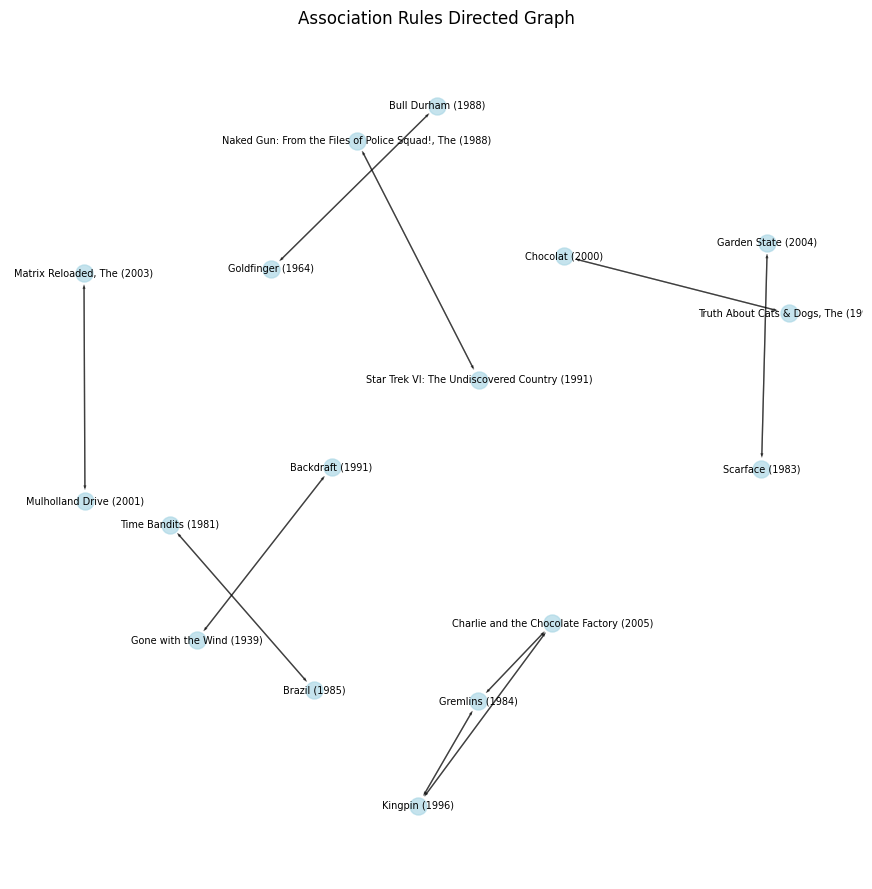

In [149]:
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules
def plot_topk_rules_in_graph(rules, frequent_itemsets, k=20):

    # Create a directed graph
    G = nx.DiGraph()
    narrow_rules = rules.sort_values(by='lift', ascending=False).head(k)
    # Add nodes and directed edges
    for _, rule in narrow_rules.iterrows():
        antecedent = ', '.join(list(rule['antecedents']))
        consequent = ', '.join(list(rule['consequents']))

        # Add a directed edge from antecedent to consequent
        G.add_edge(antecedent, consequent)

    # Draw the directed graph
    plt.figure(figsize=(11, 11))
    pos = nx.spring_layout(G, k=0.5, iterations=20)  # Layout for the graph

    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=150, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, arrowstyle='->', arrowsize=3)
    nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')

    # Add edge labels (optional, if you want to display lift, confidence, or support)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Association Rules Directed Graph")
    plt.axis('off')
    plt.show()

plot_topk_rules_in_graph(rules, frequent_itemsets)

max lift value is 112.61999999999999
max confidence value is 0.10526315789473684


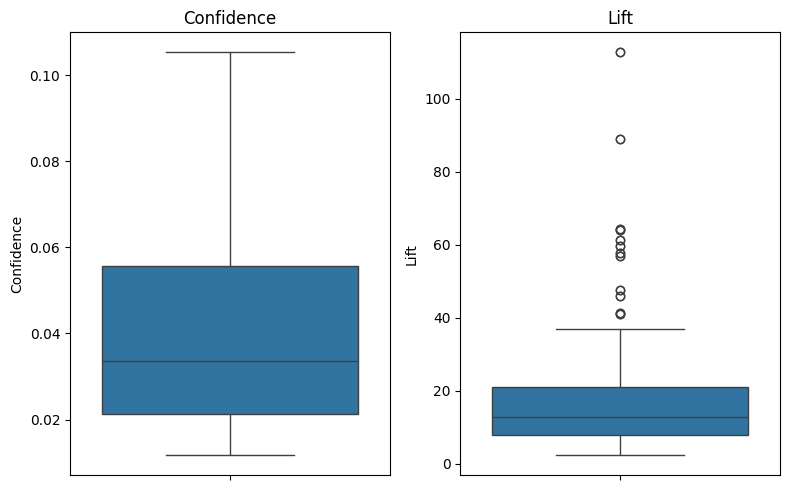

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics_boxplots(rules):
  if not rules.empty:


      print(f"max lift value is {rules['lift'].max()}")
      print(f"max confidence value is {rules['confidence'].max()}")

      fig, axes = plt.subplots(1, 2, figsize=(8, 5))

      # plot Confidence
      sns.boxplot(data=rules['confidence'], ax=axes[0])
      axes[0].set_title('Confidence')
      axes[0].set_ylabel('Confidence')

      # plot Lift
      sns.boxplot(data=rules['lift'], ax=axes[1])
      axes[1].set_title('Lift')
      axes[1].set_ylabel('Lift')

      # show plot
      plt.tight_layout()
      plt.show()
  else:
      print("No rules to plot.")



plot_metrics_boxplots(rules)


# Cluster items + Apriori


In [132]:
from sklearn.cluster import KMeans


def add_cluster_users_col(num_clusters, transactions_matrix):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    user_clusters = kmeans.fit_predict(transactions_matrix)
    transactions_matrix['Cluster'] = user_clusters


num_clusters = 40
add_cluster_users_col(num_clusters,user_movie_matrix_with_titles)
df = user_movie_matrix_with_titles

<ipython-input-137-19510a52c52c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


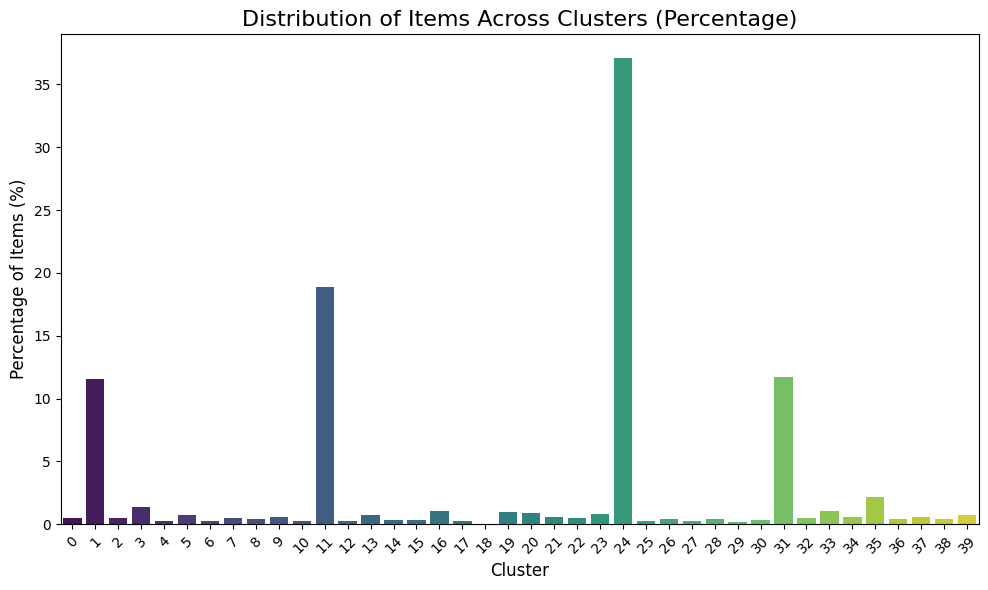

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the distribution of clusters
cluster_counts = df['Cluster'].value_counts().sort_index()

# Calculate percentages
cluster_percentages = (cluster_counts / cluster_counts.sum()) * 100

# Plot the distribution using seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Items Across Clusters (Percentage)', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage of Items (%)', fontsize=12)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [150]:
from sklearn.metrics import silhouette_score
score=silhouette_score(df, df['Cluster'])
print(f"silhouette score of clustering is: {score}")


silhouette score is: 0.25924274466594444


In [153]:

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered in divide*")
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*DataFrames with non-bool types result in worse computationalperformance*")

# Function to process a single cluster
def process_cluster(cluster_id, df, min_support):
    print(f"\nProcessing Cluster {cluster_id}...")

    # Extract transactions of current cluster
    cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])

    # Run Apriori
    from mlxtend.frequent_patterns import fpgrowth, association_rules

    scale_k = min_support  * np.sqrt(len(transactions))
    min_support =  scale_k / np.sqrt(len(cluster_data)) if len(cluster_data) > 0 else 0
    print(f"min_support: {min_support}")


    frequent_itemsets = fpgrowth(cluster_data, min_support=min_support, use_colnames=True)
    if frequent_itemsets.empty:
        print(f"No frequent itemsets found in Cluster {cluster_id}.")
        return None

    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    print(f"Cluster {cluster_id}: {len(rules)} rules generated.")

    return cluster_id, {"frequent_itemsets": frequent_itemsets, "rules": rules}
def find_clusters_rules(df, min_support):
  # Process clusters sequentially (without parallel computation)
  cluster_results = {}
  # Loop through all unique cluster IDs
  for cluster_id in sorted(df['Cluster'].unique()):
      if df['Cluster'].value_counts()[cluster_id] < 30:
          cluster_results[cluster_id] = cluster_id, {"frequent_itemsets": None, "rules": None}
          continue
      cluster_results[cluster_id] = process_cluster(cluster_id, df, min_support)
  return cluster_results

# pass the min support determined for the **baseline** whole dataset rule generation approach (will be scaled to match the smaller clusters)
cluster_results = find_clusters_rules(df, 0.00005)


Processing Cluster 0...
min_support: 0.0007288528075642843
Cluster 0: 318 rules generated.

Processing Cluster 1...
min_support: 0.00014693963954192775


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Cluster 1: 2938 rules generated.

Processing Cluster 2...
min_support: 0.000687890454440912
Cluster 2: 298 rules generated.

Processing Cluster 3...
min_support: 0.0004208033646468541
Cluster 3: 370 rules generated.

Processing Cluster 4...
min_support: 0.0009236784170813012
Cluster 4: 58 rules generated.

Processing Cluster 5...
min_support: 0.000587758558167711


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  ce

Cluster 5: 130 rules generated.

Processing Cluster 6...
min_support: 0.000985323332193812
Cluster 6: 196 rules generated.

Processing Cluster 7...
min_support: 0.0006967288098555697
Cluster 7: 230 rules generated.

Processing Cluster 8...
min_support: 0.0007823459703937283
Cluster 8: 186 rules generated.

Processing Cluster 9...
min_support: 0.0006506792286884656
Cluster 9: 212 rules generated.

Processing Cluster 10...
min_support: 0.0009607886105165698
Cluster 10: 164 rules generated.

Processing Cluster 11...
min_support: 0.00011501141286016011
Cluster 11: 8642 rules generated.

Processing Cluster 12...
min_support: 0.0010027640371920575
Cluster 12: 124 rules generated.

Processing Cluster 13...
min_support: 0.0005841855247031779
Cluster 13: 410 rules generated.

Processing Cluster 14...
min_support: 0.0008139229621010174
Cluster 14: 110 rules generated.

Processing Cluster 15...
min_support: 0.0008782766437824126
Cluster 15: 112 rules generated.

Processing Cluster 16...
min_suppo

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be dis

min_support: 0.0009607886105165698
Cluster 17: 134 rules generated.

Processing Cluster 19...
min_support: 0.0005070732567107369
Cluster 19: 374 rules generated.

Processing Cluster 20...
min_support: 0.0005241020194859664
Cluster 20: 498 rules generated.

Processing Cluster 21...
min_support: 0.0006364808824065848
Cluster 21: 222 rules generated.

Processing Cluster 22...


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be dis

min_support: 0.0006907990951286116
Cluster 22: 128 rules generated.

Processing Cluster 23...
min_support: 0.0005532021408993752
Cluster 23: 224 rules generated.

Processing Cluster 24...


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


min_support: 8.205135390222363e-05


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Cluster 24: 4078 rules generated.

Processing Cluster 25...
min_support: 0.0009607886105165698
Cluster 25: 66 rules generated.

Processing Cluster 26...
min_support: 0.0007503998933901843
Cluster 26: 520 rules generated.

Processing Cluster 27...
min_support: 0.0009687620966986684
Cluster 27: 80 rules generated.

Processing Cluster 28...
min_support: 0.0007619156540704003
Cluster 28: 96 rules generated.

Processing Cluster 29...
min_support: 0.0011064042817987504
Cluster 29: 32 rules generated.

Processing Cluster 30...
min_support: 0.000903375313212476


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be dis

Cluster 30: 116 rules generated.

Processing Cluster 31...
min_support: 0.0001462681677594139
Cluster 31: 3118 rules generated.

Processing Cluster 32...
min_support: 0.0007154782253214216
Cluster 32: 146 rules generated.

Processing Cluster 33...
min_support: 0.0004895069164747274
Cluster 33: 950 rules generated.

Processing Cluster 34...
min_support: 0.0006482467744593991
Cluster 34: 220 rules generated.

Processing Cluster 35...
min_support: 0.00033969007089153355


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be dis

Cluster 35: 682 rules generated.

Processing Cluster 36...
min_support: 0.0007430066106902494
Cluster 36: 116 rules generated.

Processing Cluster 37...
min_support: 0.0006482467744593991
Cluster 37: 240 rules generated.

Processing Cluster 38...
min_support: 0.0007658736841020196
Cluster 38: 68 rules generated.

Processing Cluster 39...
min_support: 0.0005969861012312524
Cluster 39: 312 rules generated.


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_n

    Avg Support  Avg Confidence     Avg Lift
0      0.009493        0.780112    59.377358
1      0.000385        0.528726   697.041302
2      0.008516        0.808800    73.862528
3      0.003196        0.724044   147.977806
4      0.015152        0.609457    14.448276
5      0.006324        0.663709    53.338462
6      0.017241        0.779381    32.408163
7      0.008996        0.743441    56.434783
8      0.010870        0.776648    50.903226
9      0.007590        0.653150    41.964909
10     0.016393        0.778089    33.926829
11     0.000237        0.582054  1500.202352
12     0.018145        0.734591    26.258065
13     0.006090        0.764941    87.809371
14     0.011765        0.721497    37.654545
15     0.013943        0.744741    35.714286
16     0.004301        0.730763   110.836483
17     0.016393        0.794470    35.925373
18     0.000000        0.000000     0.000000
19     0.004591        0.769582   119.224538
20     0.004898        0.780991   119.661327
21     0.0

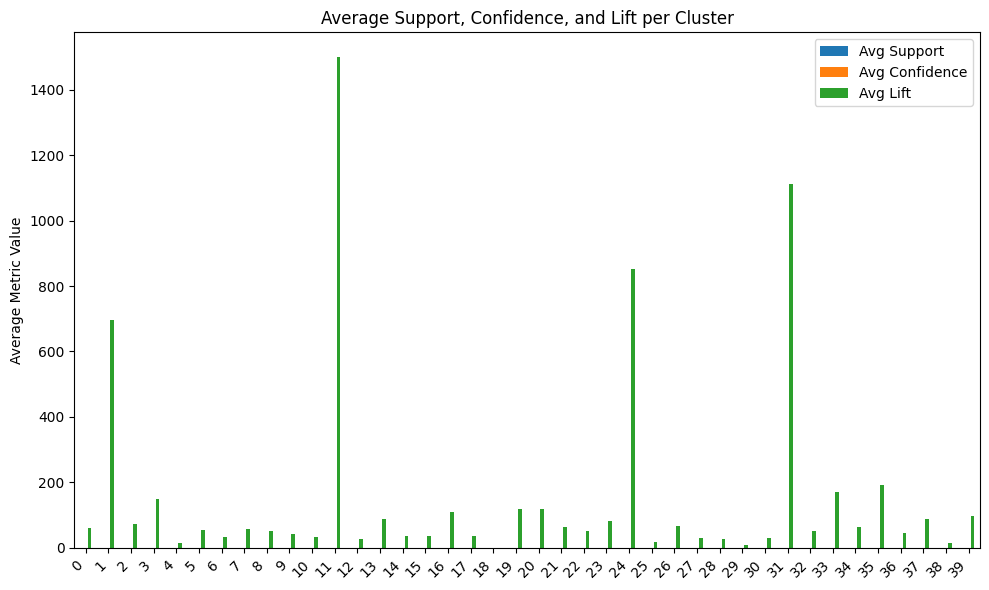

In [154]:
import matplotlib.pyplot as plt

# Initialize dictionary to store average metrics per cluster
cluster_metrics = {}

for cluster_id, data in cluster_results.items():
    # Access the dictionary that is the second element of the tuple
    rules = data[1]["rules"]

    if rules is not None and not rules.empty:
        avg_support = rules["support"].mean()
        avg_confidence = rules["confidence"].mean()
        avg_lift = rules["lift"].mean()
    else:
        avg_support, avg_confidence, avg_lift = 0, 0, 0  # Handle empty clusters

    cluster_metrics[cluster_id] = {
        "Avg Support": avg_support,
        "Avg Confidence": avg_confidence,
        "Avg Lift": avg_lift
    }

# Convert dictionary to DataFrame for easier plotting
metrics_df = pd.DataFrame.from_dict(cluster_metrics, orient="index")
print(metrics_df)

# Plotting the metrics
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric for every cluster
metrics_df.plot(kind='bar', ax=ax)

# Adding labels and title
ax.set_ylabel('Average Metric Value')
ax.set_title('Average Support, Confidence, and Lift per Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()


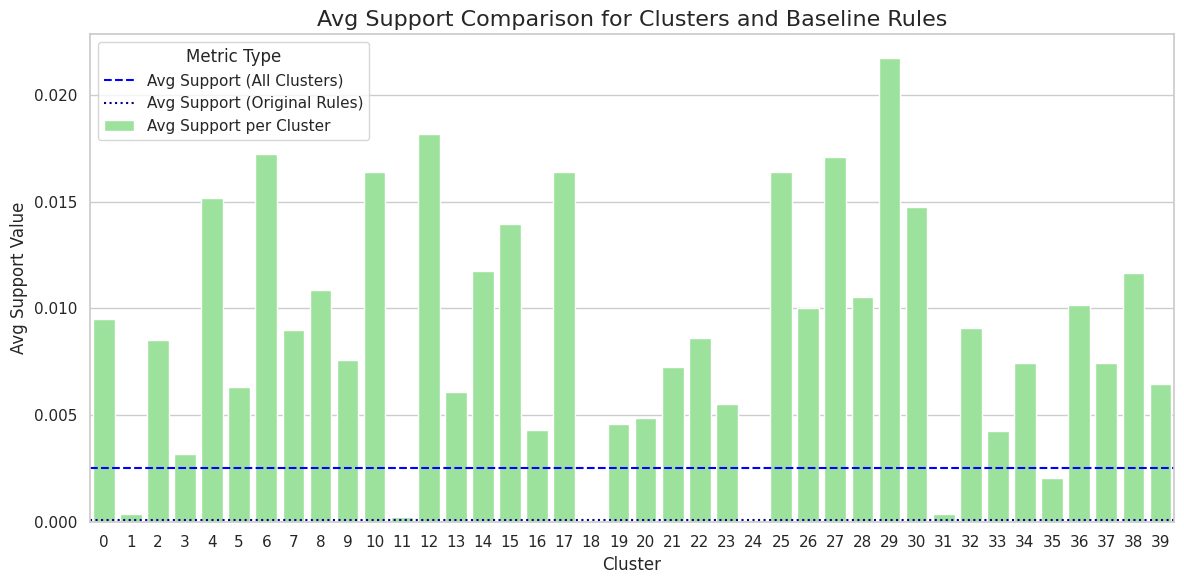

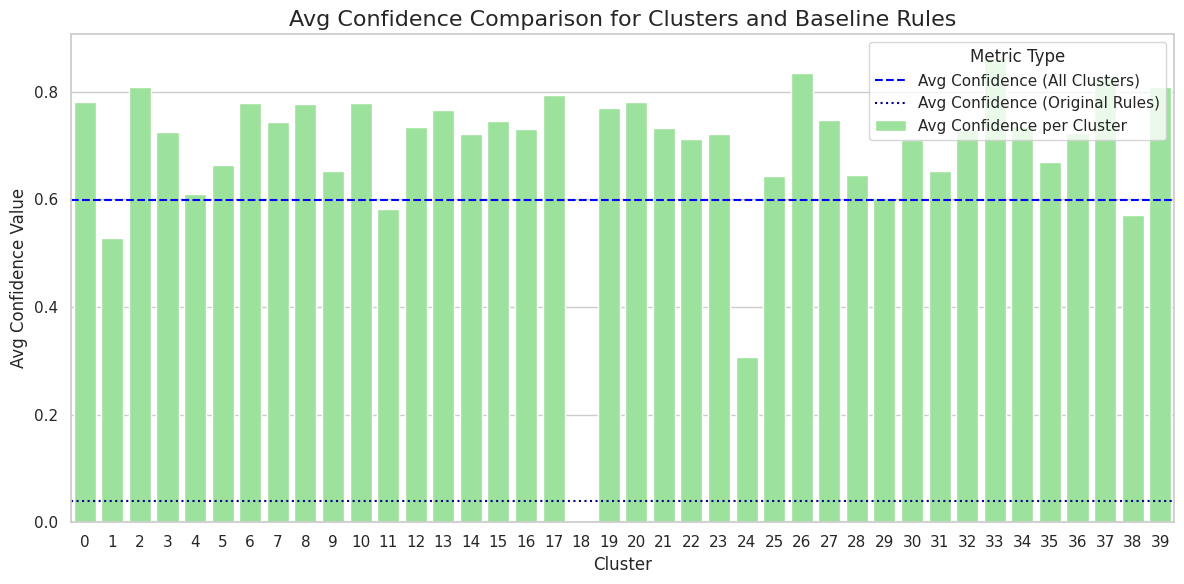

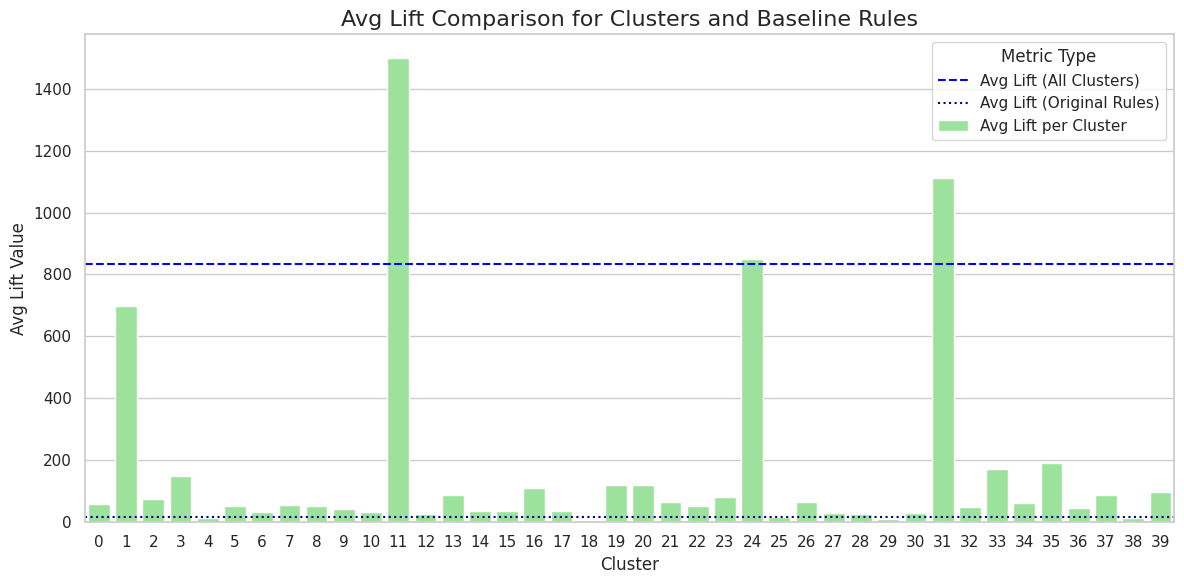

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize lists to store data for plotting
cluster_metrics_list = []
overall_metrics = {
    'Lift': [],
    'Confidence': [],
    'Support': [],
    'All Clusters': [],
    'Original Rules': []
}

# Extract the metrics for each cluster
for cluster_id, data in cluster_results.items():
    rules = data[1]["rules"]
    if rules is not None and not rules.empty:
        avg_support = rules["support"].mean()
        avg_confidence = rules["confidence"].mean()
        avg_lift = rules["lift"].mean()
    else:
        avg_support, avg_confidence, avg_lift = 0, 0, 0  # Handle empty clusters

    # Add metrics to the list for each cluster
    cluster_metrics_list.append({
        'Cluster': cluster_id,
        'Avg Support': avg_support,
        'Avg Confidence': avg_confidence,
        'Avg Lift': avg_lift
    })

# Calculate the metrics for all clusters combined
all_rules_df = pd.concat([data[1]["rules"] for cluster_id, data in cluster_results.items() if data[1]["rules"] is not None], ignore_index=True)
if not all_rules_df.empty:
    avg_support_all_clusters = all_rules_df["support"].mean()
    avg_confidence_all_clusters = all_rules_df["confidence"].mean()
    avg_lift_all_clusters = all_rules_df["lift"].mean()
else:
    avg_support_all_clusters = avg_confidence_all_clusters = avg_lift_all_clusters = 0

# Add all clusters combined metrics to overall metrics
overall_metrics['All Clusters'] = [avg_support_all_clusters, avg_confidence_all_clusters, avg_lift_all_clusters]

# Calculate the metrics for the original (baseline) rules
original_rules_df = original_rules  # Assuming you have the baseline rules in 'original_rules'
if not original_rules_df.empty:
    avg_support_original = original_rules_df["support"].mean()
    avg_confidence_original = original_rules_df["confidence"].mean()
    avg_lift_original = original_rules_df["lift"].mean()
else:
    avg_support_original = avg_confidence_original = avg_lift_original = 0

# Add original rules metrics to overall metrics
overall_metrics['Original Rules'] = [avg_support_original, avg_confidence_original, avg_lift_original]

# Convert cluster metrics list into a DataFrame for easier plotting
cluster_metrics_df = pd.DataFrame(cluster_metrics_list)

# Prepare the data for plotting each metric separately
metrics = ['Avg Support', 'Avg Confidence', 'Avg Lift']
overall_values = {
    'All Clusters': overall_metrics['All Clusters'],
    'Original Rules': overall_metrics['Original Rules']
}

# Create individual plots for each metric (Support, Confidence, Lift)
for metric in metrics:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the metrics for each cluster
    sns.barplot(x='Cluster', y=metric, data=cluster_metrics_df, color='lightgreen', label=f'{metric} per Cluster', ax=ax)

    # Plot the overall metrics (all clusters and original rules)
    ax.axhline(y=overall_values['All Clusters'][metrics.index(metric)], color='blue', linestyle='--', label=f'{metric} (All Clusters)')
    ax.axhline(y=overall_values['Original Rules'][metrics.index(metric)], color='darkblue', linestyle=':', label=f'{metric} (Original Rules)')

    # Add labels and title
    ax.set_title(f'{metric} Comparison for Clusters and Baseline Rules', fontsize=16)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(f'{metric} Value', fontsize=12)
    ax.legend(title='Metric Type')

    # Show the plot
    plt.tight_layout()
    plt.show()
